In [1]:
import time
import numpy as np
import pandas as pd

from scipy.stats import chi2_contingency
 
import seaborn as sns
import matplotlib.pyplot as plt

### Load and modify data

In [2]:
########## Schema for import ##########
rd_schema = pd.read_json('../data/raw/sipp_2018/pu2018_schema.json')
rd_schema['dtype'] = (['Int64' if x == 'integer'
                       else 'object' if x == 'string'
                       else 'Float64' if x == 'float'
                       else 'ERROR'
                       for x in rd_schema['dtype']]
                     )

########## Define recoding functions ##########
def load_response_code_dict():
    import json
    with open('../data/interim/response_code_dict.json') as jf:
        response_code_dict = json.load(jf)
    return response_code_dict
def recode_df(df):
    df2 = df.copy()
    rcode_dict = load_response_code_dict()
    for col in df2.columns:
        if col in rcode_dict:
            df2[col] = (df2[col]
                        .astype(str)
                        .map(rcode_dict.get(col), na_action='ignore')
                        .fillna(df2[col])
                       )
    if 'eorigin' in df2.columns:
        df2['eorigin'] = df2['eorigin'].map({'Yes':'Hispanic', 'No':'Not Hispanic'})
                        
                      
    return df2

########## Features to import ##########
ref_cols = ['SSUID', 'PNUM', 'ERESIDENCEID', 
            'ERELRPE', 'RFAMNUM', 'RFAMREF', 
            'MONTHCODE', 'RIN_UNIV', 'WPFINWGT',
           ]
stock_core = ['EOWN_ST', 'AOWN_ST',
              'TOSTVAL', 'AOSTVAL',
              'EJOOWNST', 'TJOSTVAL',
             ]
res_core = ['TEHC_ST', 'TEHC_METRO']
demo_core = ['TAGE', 'EEDUC',
             'EORIGIN', 'ERACE', 'TRACE',
             'ESEX', 'TBORNPLACE', 'EBORNUS',
            ]
########## Concatenate features to import ##########
core_cols = (ref_cols
            + res_core
            + demo_core
            + stock_core
           )
demo_explore = ['ESPEAK', 'RAFEVER', 'RANY5',
                'RFAMKIND', 'RFPERSONS', 'RFPERSONSWT2',
                'RFRELU18', 'RFRELU18WT2', 'RLNGISOL',
                'EMS', 'ECITIZEN', 'ENATCIT',
                'TIMSTAT', 'TYRENTRY', 'EHOWWELL',
                'TLANG1', 'RHNUM65OVRT2', 
               ]
opt_cols = (demo_explore)
use_cols = core_cols + opt_cols
print(f'You are importing {len(use_cols)} total columns')

########## Load dataset. This works on my computer ##########
start = time.time()
sipp_2018 = pd.read_csv("../data/raw/sipp_2018/pu2018.csv",
                      names=rd_schema['name'],
                      dtype=dict([(i,v) for i,v in zip(rd_schema.name, rd_schema.dtype)]),
                      sep='|',
                      header=0,
                      usecols=use_cols,
                     )
end = time.time()
print(f'Read with Pandas: {end - start} seconds.')
print(f'Imported dataframe has {sipp_2018.shape[0]} rows and {sipp_2018.shape[1]} columns/s.')

########## Set df column order & reformat column names ##########
sipp_2018 = sipp_2018[use_cols]
sipp_2018.columns = [name.lower().replace(' ', '_') for name in sipp_2018.columns]

########## Collapse observations to the person level ##########
sipp_2018_person = (sipp_2018
                    .sort_values(by=['ssuid', 'pnum', 'monthcode'], 
                                 ascending=[True, True, False])
                    .drop_duplicates(['ssuid', 'pnum'])
                    .query('rin_univ > 0 and tage >= 18')
                    .drop(['monthcode', 'rin_univ'], axis='columns')
                   )

########## Delete unneeded objects ##########
del [rd_schema, sipp_2018]


print(f'There are {sipp_2018_person.shape[0]} people in the sample (sipp_2018_person dataframe).')

You are importing 42 total columns
Read with Pandas: 119.69687104225159 seconds.
Imported dataframe has 763186 rows and 42 columns/s.
There are 49704 people in the sample (sipp_2018_person dataframe).


In [3]:
########## Recode variables ##########
sipp_2018_person_recode = recode_df(sipp_2018_person)

### Engineered Columns: Bins

In [4]:
########## Bins for Age
sipp_2018_person_recode['tage_bin'] = pd.cut(sipp_2018_person_recode.tage, 
                                             bins=[18, 20, 30, 40, 50, 60, 70, np.inf],
                                             labels=['< 20', '20\'s', '30\'s', '40\'s', '50\'s', '60\'s', '70+'],                                                
                                             include_lowest=True,
                                            )
########## Bins for total stock value
sipp_2018_person_recode['tostval_bin'] = pd.cut(sipp_2018_person_recode.tostval,
                                            bins=5,
                                           )
########## Recode for total stock value
eeduc_cats = {'12th grade, no diploma': 'No HS Degree',
              '1 or more years of college, no degree (regular Jr.coll./coll./univ.)': 'Some College',
              'High School Graduate (diploma or GED or equivalent)': 'HS Degree/GED',
              '9th grade':'No HS Degree', '5th or 6th grade': 'No HS Degree', 
              '10th grade': 'No HS Degree', '7th or 8th grade': 'No HS Degree',
              '1st, 2nd, 3rd or 4th grade': 'Some College',
              "Master's degree (for example: MA, MS, MBA, MSW)": 'Master\'s degree',
              'Some college credit, but less than 1 year (regular Jr.coll./coll./univ.)': 'Some College',
              '11th grade': 'Some College', "Bachelor's degree (for example: BA, AB, BS)": 'Bachelor\'s degree',
              "Associate's degree (2-year college)": 'Some College',  
              'Doctorate degree (for example: Ph.D., Ed.D.)': 'Doctorate degree',
              'Professional School degree (for example: MD (doctor), DDS (dentist), JD (lawyer))': 'Professional School degree',
              'Less than 1st grade': 'No HS Degree'}

sipp_2018_person_recode['eeduc'] = sipp_2018_person_recode['eeduc'].map(eeduc_cats)

### Convert Categorical Variables to Category dtype

In [5]:
########### Edit this variable to adjust which columns to convert
convert_to_cat_cols = sipp_2018_person_recode.loc[:,'tehc_st':].select_dtypes(include=['object']).columns

for col in convert_to_cat_cols:
    sipp_2018_person_recode[col] = sipp_2018_person_recode[col].astype('category')

In [6]:
sipp_2018_person_recode.columns

Index(['ssuid', 'pnum', 'eresidenceid', 'erelrpe', 'rfamnum', 'rfamref',
       'wpfinwgt', 'tehc_st', 'tehc_metro', 'tage', 'eeduc', 'eorigin',
       'erace', 'trace', 'esex', 'tbornplace', 'ebornus', 'eown_st', 'aown_st',
       'tostval', 'aostval', 'ejoownst', 'tjostval', 'espeak', 'rafever',
       'rany5', 'rfamkind', 'rfpersons', 'rfpersonswt2', 'rfrelu18',
       'rfrelu18wt2', 'rlngisol', 'ems', 'ecitizen', 'enatcit', 'timstat',
       'tyrentry', 'ehowwell', 'tlang1', 'rhnum65ovrt2', 'tage_bin',
       'tostval_bin'],
      dtype='object')

In [7]:
sipp_2018_person_recode.dtypes

ssuid             object
pnum               Int64
eresidenceid      object
erelrpe           object
rfamnum            Int64
rfamref            Int64
wpfinwgt         Float64
tehc_st         category
tehc_metro      category
tage               Int64
eeduc           category
eorigin         category
erace           category
trace           category
esex            category
tbornplace      category
ebornus         category
eown_st         category
aown_st         category
tostval            Int64
aostval         category
ejoownst        category
tjostval           Int64
espeak          category
rafever         category
rany5           category
rfamkind        category
rfpersons          Int64
rfpersonswt2       Int64
rfrelu18           Int64
rfrelu18wt2        Int64
rlngisol        category
ems             category
ecitizen        category
enatcit         category
timstat         category
tyrentry        category
ehowwell        category
tlang1          category
rhnum65ovrt2       Int64


In [8]:
def cat_summary(df, feature):
    '''
    This function displays a frequency table, relative freq table, and bar chart for the chosen feature.
    inputs: 
    df - enter df variable name
    feature - enter feature name as string
    outputs:
    None
    All display items
    '''
    data_dict = pd.read_csv('../data/interim/sipp_2018_meta.csv',
                            usecols=['variable','description']
                           )
    var_description = data_dict[data_dict.variable.str.lower() == feature].description.iloc[0]
    
    print("\033[1m" + var_description + "\033[0m")

    display(df
            [feature]
            .value_counts()
            .to_frame()
            .sort_index()
            .rename(columns={feature:'freq'})
           )

    display(df
            [feature]
            .value_counts(normalize=True, dropna=False)
            .mul(100)
            .round(1)
            .to_frame()
            .sort_index()
            .rename(columns={feature:'rel freq'})
           )

    (df
     [feature]
     .value_counts()
     .to_frame()
     .sort_index()
     .plot.bar(legend=False, title=feature + ' Bar Chart')
    );

### Univariate Analysis
#### Categorical Data

In [9]:
sipp_2018_person_recode.describe(include='category')

,tehc_st,tehc_metro,eeduc,eorigin,erace,trace,esex,tbornplace,ebornus,eown_st,...,rlngisol,ems,ecitizen,enatcit,timstat,tyrentry,ehowwell,tlang1,tage_bin,tostval_bin
count,49704,49704,49704,49704,49704,49704,49704,49704,49704,49704,...,49704,49704,49704,45907,7964,7964,8392,8392,49704,4139
unique,52,3,7,2,4,21,2,59,2,2,...,2,6,2,4,2,22,4,12,7,4
top,California,Metropolitan area,Some College,Not Hispanic,White alone,White alone,Female,Americas and Caribbean,Yes,No,...,Not in a limited English-speaking household,"Married, spouse present",Yes,Island Area or born in the United States,Permanent,Year,Very well,Spanish or Spanish Creole,50's,"(-1930.0, 386000.0]"
freq,6365,38901,15902,41489,39224,39224,26046,4695,40852,43927,...,48679,25078,45907,40852,4830,809,5127,5002,8707,3809


In [10]:
sipp_2018_person_recode.groupby('eorigin').tlang1.value_counts(dropna=False).to_frame()

tlang1
eorigin      tlang1                                  
Hispanic     Spanish or Spanish Creole           4726
             NaN                                 3315
             Other                                146
             Chinese                                8
             French Creole                          6
             German                                 5
             Tagalog, Filipino                      4
             Arabic                                 3
             French (including Patois, Cajun)       2
Not Hispanic NaN                                37997
             Other                               1438
             Chinese                              348
             Tagalog, Filipino                    291
             Spanish or Spanish Creole            276
             Hindi, Urdu                          250
             Vietnamese                           211
             Arabic                               149
             Korean                               126
             Russian                              119
             French (including Patois, Cajun)     116
             French Creole                         90
             German                                78

What is the highest level of school ... completed or the highest degree received by December of (reference year)?


,freq
Bachelor's degree,9524
Doctorate degree,763
HS Degree/GED,14176
Master's degree,4192
No HS Degree,4391
Professional School degree,756
Some College,15902


,rel freq
Bachelor's degree,19.2
Doctorate degree,1.5
HS Degree/GED,28.5
Master's degree,8.4
No HS Degree,8.8
Professional School degree,1.5
Some College,32.0


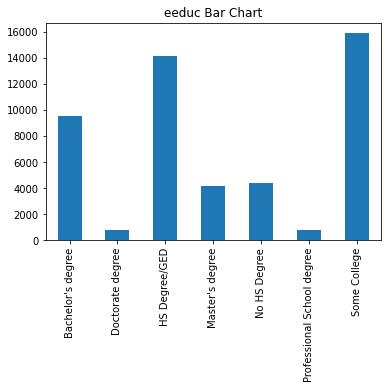

In [11]:
cat_summary(sipp_2018_person_recode, 'eeduc')

### Weighted Data Quick Comparison

In [12]:
sipp_2018_person_recode.groupby('eown_st').wpfinwgt.sum().mul(100).div(sipp_2018_person_recode.wpfinwgt.sum())

eown_st
No     87.850955
Yes    12.149045
Name: wpfinwgt, dtype: Float64

In [13]:
sipp_2018_person_recode.eown_st.value_counts(normalize=True).mul(100)

No     88.377193
Yes    11.622807
Name: eown_st, dtype: float64

### Univariate Freq, Relative Freq, and Bar Charts

Is ... Spanish, Hispanic, or Latino?


,freq
Hispanic,8215
Not Hispanic,41489


,rel freq
Hispanic,16.5
Not Hispanic,83.5


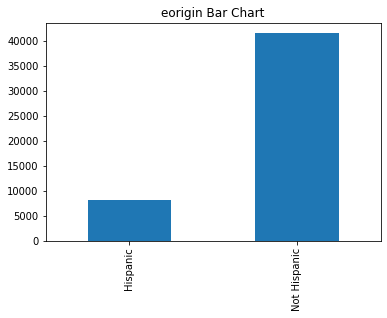

In [14]:
cat_summary(sipp_2018_person_recode, 'eorigin')

What race(s) does ... consider herself/himself to be?


,freq
Asian alone,2845
Black alone,5869
Residual,1766
White alone,39224


,rel freq
Asian alone,5.7
Black alone,11.8
Residual,3.6
White alone,78.9


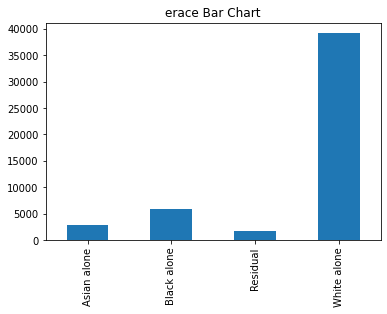

In [15]:
cat_summary(sipp_2018_person_recode, 'erace')

In [16]:
cat_columns = sipp_2018_person_recode.loc[:,'eorigin':].select_dtypes(include=['object', 'category']).columns.to_list()

Is ... Spanish, Hispanic, or Latino?


,freq
Hispanic,8215
Not Hispanic,41489


,rel freq
Hispanic,16.5
Not Hispanic,83.5


What race(s) does ... consider herself/himself to be?


,freq
Asian alone,2845
Black alone,5869
Residual,1766
White alone,39224


,rel freq
Asian alone,5.7
Black alone,11.8
Residual,3.6
White alone,78.9


What race(s) does ... consider herself/himself to be? (detailed categories)


,freq
AI-Asian,2
American Indian or Alaska Native alone (AI),542
Asian alone,2845
Asian-HP,25
Black alone,5869
Black-AI,81
Black-Asian,15
Black-HP,1
Native Hawaiian or Other Pacific Islander alone (HP),155
Other 2 or 3 races,4


,rel freq
AI-Asian,0.0
American Indian or Alaska Native alone (AI),1.1
Asian alone,5.7
Asian-HP,0.1
Black alone,11.8
Black-AI,0.2
Black-Asian,0.0
Black-HP,0.0
Native Hawaiian or Other Pacific Islander alone (HP),0.3
Other 2 or 3 races,0.0


Sex of this person


,freq
Female,26046
Male,23658


,rel freq
Female,52.4
Male,47.6


Recoded Place of Birth


,freq
99,2
Africa,406
Alabama,807
Alaska,111
Americas and Caribbean,4695
Arizona,469
Arkansas,485
Asia and Pacific Islands,2580
California,4275
Colorado,470


,rel freq
99,0.0
Africa,0.8
Alabama,1.6
Alaska,0.2
Americas and Caribbean,9.4
Arizona,0.9
Arkansas,1.0
Asia and Pacific Islands,5.2
California,8.6
Colorado,0.9


Where was ... born?


,freq
No,8852
Yes,40852


,rel freq
No,17.8
Yes,82.2


Owned any stocks during the reference period [excluding stock-options].


,freq
No,43927
Yes,5777


,rel freq
No,88.4
Yes,11.6


IndexError: single positional indexer is out-of-bounds

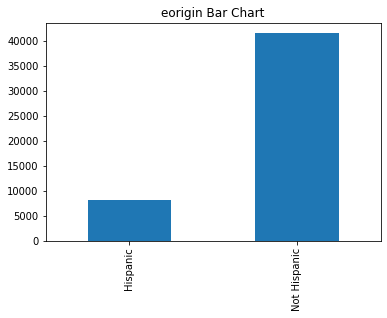

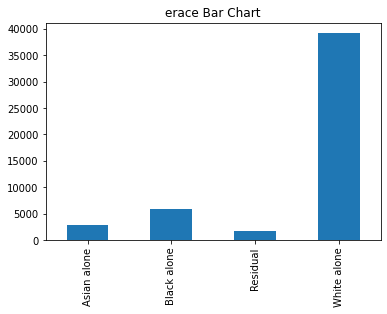

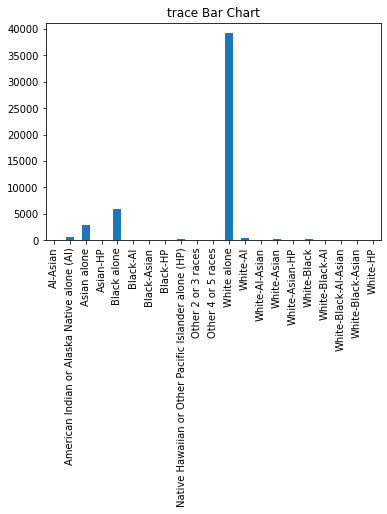

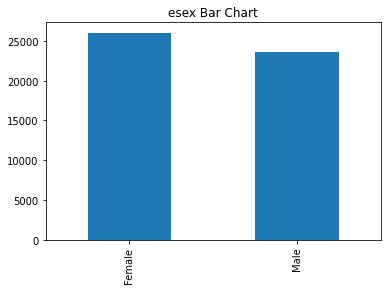

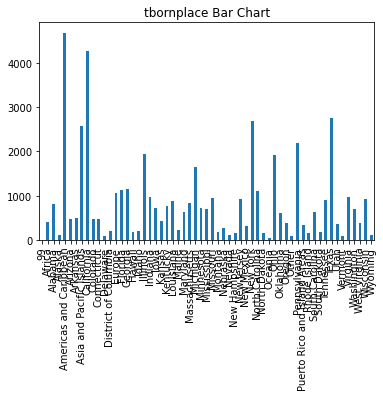

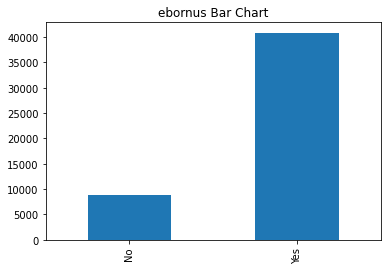

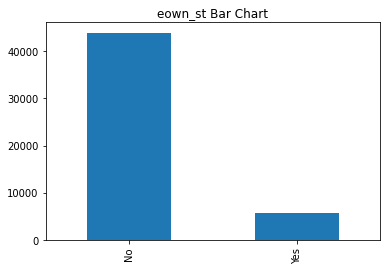

In [17]:
for col in cat_columns:
    cat_summary(sipp_2018_person_recode, col)

### Chi-Square Test
#### Categorical Independent Variable and Categorical Dependent Variable Independence Test

In [18]:
def feature_test_chi2(df, e_var, r_var):
    '''
    Function performs a chi-sq test on categorical variables from within a single dataframe
    and returns a dataframe with results.
    
    This was created to run a batch chi-2 tests between many explanatory variables and a single
    response variable, all originating from the same dataframe.
    
    Inputs:
    df - string; name of dataframe as a string
    e_var - a string or list of strings; column names from within dataframe above 
        to be used as the explanatory variable in the chi-sq tests
    r_var - string; column name from within df above that has values to be used as response variable
    
    Output:
    dataframe - columns list variables and chi-sq results (chi-sq value, p-value, and degrees of freedom
    '''
    
    chi2_results = pd.DataFrame(columns=['explanatory_variable',
                                         'response_variable', 'n', 
                                         'chi^2', 'p', 'dof',
                                        ]
                               )
    p = None
    if type(e_var) == str:
        e_var = [e_var]
    
    for iv_column in e_var:
        contingency = pd.crosstab(df[iv_column], df[r_var], margins=True)
        
        var_list = [iv_column, r_var, contingency.iloc[-1, -1]]
        results_list = list(chi2_contingency(contingency)[:3])
        combined_list = var_list + results_list
        
        
        results_df = pd.DataFrame([combined_list], 
                                  columns=['explanatory_variable',
                                           'response_variable', 'n',
                                           'chi^2', 'p', 'dof',
                                          ]
                                 )
        chi2_results = chi2_results.append(results_df)
        
    return chi2_results

In [27]:
c1 = pd.crosstab(sipp_2018_person_recode.esex, sipp_2018_person_recode.eown_st, margins=True)
c1

eown_st,No,Yes,All
esex,,,
Female,23422,2624,26046
Male,20505,3153,23658
All,43927,5777,49704


In [24]:
chi2_contingency(c1)

(127.39397729028016,
 1.5232469240997846e-29,
 1,
 array([[23018.72368421,  3027.27631579],
        [20908.27631579,  2749.72368421]]))

In [19]:
category_list = list(sipp_2018_person_recode.select_dtypes('category').columns)
category_list

['tehc_st',
 'tehc_metro',
 'eeduc',
 'eorigin',
 'erace',
 'trace',
 'esex',
 'tbornplace',
 'ebornus',
 'eown_st',
 'aown_st',
 'aostval',
 'ejoownst',
 'espeak',
 'rafever',
 'rany5',
 'rfamkind',
 'rlngisol',
 'ems',
 'ecitizen',
 'enatcit',
 'timstat',
 'tyrentry',
 'ehowwell',
 'tlang1',
 'tage_bin',
 'tostval_bin']

In [20]:
chi2_results_df = (feature_test_chi2(sipp_2018_person_recode, category_list, 'eown_st')
                   .sort_values(by='p')
                   .reset_index(drop=True)
                  )
chi2_results_df[chi2_results_df.p < 0.01]

,explanatory_variable,response_variable,n,chi^2,p,dof
0,eeduc,eown_st,49704,2810.085360,0.000000e+00,14
1,aostval,eown_st,49704,34330.851000,0.000000e+00,10
2,eown_st,eown_st,49704,49704.000000,0.000000e+00,4
3,tage_bin,eown_st,49704,1053.251233,5.835083e-216,14
4,ems,eown_st,49704,902.655710,1.544933e-185,12
5,eorigin,eown_st,49704,743.794648,1.144547e-159,4
6,rfamkind,eown_st,36943,531.817244,1.172342e-111,6
7,tbornplace,eown_st,49704,839.939999,2.813127e-109,118
8,erace,eown_st,49704,480.192395,1.247351e-98,8
9,trace,eown_st,49704,509.411312,1.421494e-81,42


In [28]:
category_list2 = list(sipp_2018_person_recode.select_dtypes(int).columns)
category_list2

['pnum',
 'rfamnum',
 'rfamref',
 'tage',
 'tostval',
 'tjostval',
 'rfpersons',
 'rfpersonswt2',
 'rfrelu18',
 'rfrelu18wt2',
 'rhnum65ovrt2']